In [1]:
import numpy as np 
import pandas as pd
import random
import matplotlib.pyplot as plt

In [2]:
# Load csv file and convert data into numpy array
df = pd.read_csv('loadDistribution.csv')
df = df.drop(columns=["Unnamed: 0"])
data = df.to_numpy()
df

,Job 1,Job 2,Job 3,Job 4,Job 5,Job 6,Job 7,Job 8,Job 9,Job 10,Job 11
0,10,12,15,13,20,17,33,26,16,21,17
1,21,20,28,27,35,36,60,48,33,40,30
2,8,14,14,16,23,20,30,24,18,19,19
3,15,17,20,17,32,27,47,34,24,32,25
4,12,12,16,21,15,20,25,32,18,18,22
5,18,26,22,24,42,36,66,45,32,44,31
6,17,16,22,18,22,18,32,26,16,20,25


In [3]:
# Problem model
class Model:
    def __init__(self, data):
        # Durations is the original data
        self.durations = data
        # The number of nodes
        self.n_nodes = len(data)
        # The number of jobs
        self.n_jobs = len(data[0])
        # The total runtime cannot exceed the possbile maximum 
        # total runtime
        self.max_possible_total_runtime = sum([max(data[:,i]) for i in range(self.n_jobs)])
        # Each element in variables array represents
        # the runtime of node whose id corresponding
        # to the array index
        self.variables = np.zeros(self.n_nodes+1)
    
    def info(self):
        print("The maximum possible total runtime:", self.max_possible_total_runtime)
        print("The number of node workers:", self.n_nodes)
        print("The number of jobs:", self.n_jobs)
        
    # The objective function value is defined by the largest 
    # runtime among the node runtimes
    def obj_func(self):
        return max(self.variables)
    
    # Accumlate the total runtim of each node
    def assign_job_to_node(self, node, job):
        # Get the amount of time in which the node finished the given job
        duration = self.durations[node-1][job-1]
        
        # If node has no past job, assign its runtime to a new one
        # Else, add the past runtime with a new one
        if(self.variables[node] == 0):
            self.variables[node] = duration
        else:
            self.variables[node] += duration
    
    # Reset the total runtime of each node to 0
    def refresh(self):
        self.variables = np.zeros(self.n_nodes+1)

In [4]:
class Population:
    def __init__(self, mutation_rate, n_members, data):
        self.data = data
        self.mutation_rate = mutation_rate
        self.n_members = n_members
        self.population = []
        
        # Generate population with DNA object
        # and calculate the fitness
        for i in range(self.n_members):
            self.population.append(DNA(self.data))
            self.population[i].calc_fitness()
            
    def calc_fitness(self):
        for i in range(self.n_members):
            self.population[i].calc_fitness()
    
    # Calculate the probability of picking the member based on
    # the node fintess over the total fitness of all memebers
    def calc_prob(self):
        sum_fitness = 0
        for i in range(self.n_members):
            sum_fitness += self.population[i].fitness

        for i in range(self.n_members):
            self.population[i].prob = (1 - (self.population[i].fitness / sum_fitness))
    
    # Generate next generation by select two parents with
    # high probability, then crossover them, and mutate
    # their children
    def generate_next_gen(self):
        new_population = []
        self.calc_prob()
       
        for _ in range(self.n_members):
            partnerA = self.select_one()
            partnerB = self.select_one()
            child = partnerA.crossover(partnerB)
            child.mutate(self.mutation_rate)
            child.redefine_timeline()
            new_population.append(child)

        self.population = new_population 
    
    # Select the probability of a node indicates the percentage 
    # of time that the select_one picks the node
    def select_one(self):
        index = 0
        rand = random.uniform(0, 1)
        while(rand > 0 and index < self.n_members and index > 0):
            rand = rand - self.population[index].prob
            index += 1
        index -= 1
        
        return self.population[index]

class DNA:
    def __init__(self, data):
        self.fitness = 0.0
        self.model = Model(data)
        self.prob = 0.0
        self.genes = [[] for _ in range(self.model.n_nodes+1)]
        
        # Assign random jobs to node
        for i in range(1, self.model.n_jobs+1):
            random_node = random.randint(1, self.model.n_nodes)
            self.genes[random_node].append(i)
        
        # Fill job id in timeline
        for i in range(1, self.model.n_nodes+1):
            for j in range(len(self.genes[i])):
                self.model.assign_job_to_node(node=i, job=self.genes[i][j])
    
    # Re-calculate the total runtime when the nodes are assigned
    # to the new jobs
    def redefine_timeline(self):
        self.model.refresh()
        for i in range(1, self.model.n_nodes+1):
            for j in range(len(self.genes[i])):
                self.model.assign_job_to_node(node=i, job=self.genes[i][j])
        
    # Calculate the fitness by dividing the total runtime by
    # the possible maximum total runtime
    # Pow of 2 makes the fitness function increase exponentially, which
    # raise the higher probability of picking DNA with a tiny bigger than the other
    def calc_fitness(self):
        self.fitness = (self.model.obj_func() / self.model.max_possible_total_runtime)
        self.fitness = pow(self.fitness, 2)
    
    # Inherit 50% property from parent A and 50%
    # from parent B
    def crossover(self, partner):
        new_child = DNA(self.model.durations)

        # Swap to generate new child
        changed_nodes = []
        changed_jobs = []
        for i in range(1, self.model.n_nodes+1):
            if(len(new_child.genes[i]) == 0):
                if random.uniform(0,1) < 0.5:
                    new_child.genes[i] = partner.genes[i]
                else:
                    new_child.genes[i] = self.genes[i]
                
                changed_nodes.append(i)
                changed_jobs.extend(new_child.genes[i])

        # Remove duplication
        for i in range(1, self.model.n_nodes+1):
            if i not in changed_nodes:
                for j in changed_jobs:
                    if j in new_child.genes[i]:
                        new_child.genes[i].remove(j)
                        
        return new_child
    
    # Swap their random jobs in DNA itself based on
    # the mutation rate
    def mutate(self, mutation_rate):
        for i in range(1, self.model.n_nodes+1):
            if(random.uniform(0,1) < mutation_rate):
                node_a = i
                node_b = random.randint(1, self.model.n_nodes)
                
                # Swap their jobs each other
                temp = self.genes[node_a]
                self.genes[node_a] = self.genes[node_b]
                self.genes[node_b] = temp
    
class GeneticAlgorithm:
    def __init__(self, mutation_rate, n_members, data, generations):
        self.mutation_rate = mutation_rate
        self.population = None
        self.n_members = n_members
        self.data = data
        self.chosen = []
        self.generations = generations
        self.optimal = None
        
    def find_optimal(self):
        # Generate inital population
        self.population = Population(mutation_rate=self.mutation_rate, n_members=self.n_members, data=self.data)
        
        n_generations = self.generations
        while n_generations > 0:
            # Choose the best one
            self.optimal = self.population.population[0]
            for i in range(self.n_members):
                if self.optimal.fitness > self.population.population[i].fitness:
                    self.optimal = self.population.population[i]
                    
            # Create next generation
            self.population.generate_next_gen()
            
            # Calculate fitness
            self.population.calc_fitness()
            
            n_generations -= 1
            
        return self.optimal
    
    def print_optimal(self):
        print("The total runtime to complete all jobs:", self.optimal.model.obj_func())
        for i in range(1, self.optimal.model.n_nodes + 1):
            print(f"Node {i} work on task", ", ".join([str(x) for x in self.optimal.genes[i]]))

In [23]:
from IPython.display import clear_output
import timeit

total_rumtimes = []
execution_times = []
solutions = []
n = 100
trial = [i for i in range(1, n+1)]
for i in range(n):
    gen = GeneticAlgorithm(mutation_rate=0.05, n_members=100, data=data, generations=100)
    
    starttime = timeit.default_timer()
    optimal = gen.find_optimal()
    
    solutions.append(optimal)
    total_rumtimes.append(optimal.model.obj_func())
    execution_times.append(timeit.default_timer() - starttime)
    
    gen.print_optimal()
    print(f"Trial {i+1}")
    clear_output(wait=True)

The total runtime to complete all jobs: 42.0
Node 1 work on task 6, 11
Node 2 work on task 10
Node 3 work on task 3, 8
Node 4 work on task 1, 4
Node 5 work on task 2, 7
Node 6 work on task 5
Node 7 work on task 9
Trial 100


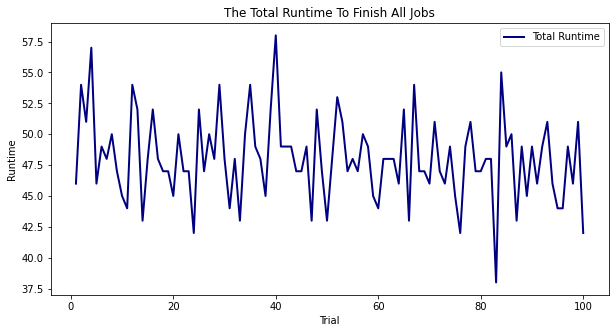

In [24]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(trial, total_rumtimes, label="Total Runtime",
             color="navy", lw=2)
ax.set_xlabel("Trial")
ax.set_ylabel("Runtime")
ax.legend(loc="best")
plt.title("The Total Runtime To Finish All Jobs")
fig.savefig("img/total_runtime.png")

In [26]:
most_optimal = [solutions[i] for i in range(n) if total_rumtimes[i] == min(total_rumtimes)]

print("The total runtime to complete all jobs:", most_optimal[0].model.obj_func())
for i in range(1, most_optimal[0].model.n_nodes + 1):
    print(f"Node {i} work on task", ", ".join([str(x) for x in most_optimal[0].genes[i]]))

The total runtime to complete all jobs: 38.0
Node 1 work on task 6, 9
Node 2 work on task 3
Node 3 work on task 2, 8
Node 4 work on task 5
Node 5 work on task 1, 7
Node 6 work on task 11
Node 7 work on task 4, 10


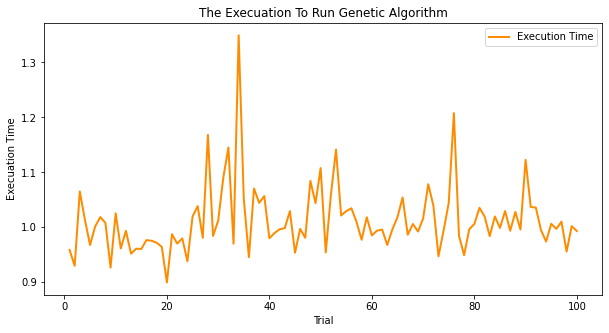

In [27]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(trial, execution_times, label="Execution Time",
             color="darkorange", lw=2)
ax.set_xlabel("Trial")
ax.set_ylabel("Execuation Time")
ax.legend(loc="best")
plt.title("The Execuation To Run Genetic Algorithm")
fig.savefig("img/execution_time.png")